# Densenet

PyTorch is a popular open source framework primarily used in NLP and computer vision applications. It was developed by Facebook AI, and is an efficient tool to implement neural networks for deep learning applications.

This notebook uses PyTorch Dense Convolutional Network (DenseNet), which connects each layer to every other layer in a feed-forward fashion. DenseNets have several compelling advantages: they alleviate the vanishing-gradient
problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters. 

Refer to this paper to find out more:
https://arxiv.org/pdf/1608.06993.pdf



#Load the pre-trained PyTorch DenseNet model

In [ ]:
import torch
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)
# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
model.eval()

#Download a video for running inference

In [ ]:
!gdown --id 1k4YUtDhpYRDIEByM-Wzpk56g4VeszUX9

Downloading...
From: https://drive.google.com/uc?id=1k4YUtDhpYRDIEByM-Wzpk56g4VeszUX9
To: /content/nature.mp4
100% 1.31M/1.31M [00:00<00:00, 106MB/s]


#Or, record a live video!

In [ ]:
#function to get video realtime
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename='video.mp4'):
  js = Javascript("""
    async function recordVideo() {
      const options = { mimeType: "video/webm; codecs=vp9" };
      const div = document.createElement('div');
      const capture = document.createElement('button');
      const stopCapture = document.createElement("button");
      capture.textContent = "Start Recording";
      capture.style.background = "green";
      capture.style.color = "white";

      stopCapture.textContent = "Stop Recording";
      stopCapture.style.background = "red";
      stopCapture.style.color = "white";
      div.appendChild(capture);

      const video = document.createElement('video');
      const recordingVid = document.createElement("video");
      video.style.display = 'block';

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      
      let recorder = new MediaRecorder(stream, options);
      document.body.appendChild(div);
      div.appendChild(video);

      video.srcObject = stream;

      await video.play();


      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      await new Promise((resolve) => {
        capture.onclick = resolve;
      });
      recorder.start();
      capture.replaceWith(stopCapture);
      await new Promise((resolve) => stopCapture.onclick = resolve);
      recorder.stop();

      let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
      let arrBuff = await recData.data.arrayBuffer();
      stream.getVideoTracks()[0].stop();
      div.remove();

      let binaryString = "";
      let bytes = new Uint8Array(arrBuff);
      bytes.forEach((byte) => {
        binaryString += String.fromCharCode(byte);
      })
      return btoa(binaryString);
    }
    """)
  try:
    display(js)
    data = eval_js('recordVideo({})')
    binary = b64decode(data)
    with open(filename, "wb") as video_file:
      video_file.write(binary)
    print(
        f"Finished recording video. Saved binary under filename in current working directory: {filename}"
    )
  except Exception as err:
      print(str(err))
  return filename

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_width = 300

video_path = record_video()
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

<IPython.core.display.Javascript object>

Finished recording video. Saved binary under filename in current working directory: video.mp4


#Define a function to extract images from the frames of a video

This function takes the number of seconds (num_seconds) and the video file (vid_file) as paramters, and extracts images from the frames of the vid_file every num_seconds. These images are written to a folder, named 

In [ ]:
#READ A VIDEO HERE AND EXTRACT IMAGES EVERY N SECONDS
import cv2 as cv
import os
import time
from datetime import datetime
from google.colab.patches import cv2_imshow


def read_vid_and_extract(num_seconds, vid_file):
    file = vid_file
    if not os.path.isfile(file):
        print("File not found!")
    folder_name = os.path.basename(file) + "frames"
    current_path = os.getcwd()
    folder_path = os.path.join(current_path, folder_name)
    print(folder_path)
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
        print('here')
    cap = cv.VideoCapture(vid_file)
    cap1= cv.VideoCapture(vid_file)
    # total_frame = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) :  although faster, this gives an error with live feed
    total_frame=0
    while True:
        ret1, frame1 = cap1.read()
        if not ret1:
            break
        total_frame += 1
    seconds = int(num_seconds)
    fps = cap.get(cv.CAP_PROP_FPS)
    multiplier = fps * seconds
    frame_counter = 1
    i=0
    if (cap.isOpened()== False):
        print("Error opening video stream or file")


    while frame_counter <= total_frame:
        cap.set(cv.CAP_PROP_POS_FRAMES, frame_counter)
        ret, frame = cap.read()
        cv2_imshow(frame)
        i+=1
        print(i)
        filename = folder_path+'/'+'Frame_'+str(i)+'.jpg'
        cv.imwrite(filename, frame)
        frame_counter += multiplier
    
    return folder_path

In [ ]:
#The current working directory, with the sample video and/or the live video
!ls

dog.jpg		      nature.mp4  sample_data  video.mp4frames
imagenet_classes.txt  output.pdf  video.mp4


In [ ]:
vidfile= 'video.mp4' #Enter the filename here, put "video.mp4" if live feed
folder_path= read_vid_and_extract(1,vidfile) 

#Define a function to simulate execution and run inference

In [ ]:
from PIL import Image
from torchvision import transforms
def exec(filename):
    input_image = Image.open(filename)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) 
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    return probabilities

##Install captioning requirements

In [ ]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-02-14 09:22:29--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-02-14 09:22:29 (67.2 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]




#Run inference on a sample image

In [ ]:
# Download an example image from the pytorch website
import urllib
url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg") #you can put your own URL and filename here
try: urllib.URLopener().retrieve(url, filename)
except: urllib.request.urlretrieve(url, filename)

In [ ]:
# Read the categories
probabilities= exec("dog.jpg")
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
topn_prob, topn_catid = torch.topk(probabilities, 5) #YOU CAN ENTER YOUR OWN N HERE TO GET TOP N CATEGORIES
for i in range(topn_prob.size(0)):
    print(categories[topn_catid[i]], topn_prob[i].item())

Samoyed 0.8871841430664062
Pomeranian 0.02883891761302948
white wolf 0.0234114658087492
keeshond 0.018629040569067
Great Pyrenees 0.00962114054709673


#Run inference on the video

In [ ]:
all_imgs = []
img_names=[]
img_exts=[]
path = folder_path
valid_images = [".jpg",".gif",".png",".tga",".jpeg"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    
    if ext.lower() not in valid_images:
        continue
    all_imgs.append(Image.open(os.path.join(path,f)))
    img_names.append(os.path.splitext(f)[0])
    img_exts.append(os.path.splitext(f)[1])  
    

restext=[]
for i in range(0,len(all_imgs)):
    li=[]
    pic_path= folder_path+'/'+img_names[i]+img_exts[i]
    probabilities= exec(pic_path)
    with open("imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        for i in range(top5_prob.size(0)):
            li.append(categories[top5_catid[i]]+ str(top5_prob[i].item()))
    restext.append(li)

## Display resulting captions with images, and save it to output.pdf

In [ ]:

import requests
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from io import BytesIO

def view_img_caption_pair(restext, image_path):
  
  text = restext
  if image_path.startswith('http'):
    response = requests.get(image_path)
    im = np.array(Image.open(BytesIO(response.content)))
  else:
    im  = np.array(load_img(image_path))
  fig, ax = plt.subplots(1, 2, figsize = (10,10))

  ax[0].imshow(im)
  ax[0].axis('off')
  ax[0].set_title('Image', fontsize = 15)

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax[1].set_xlim([0,0.5])
  ax[1].set_ylim([0,0.5])
  ax[1].text(0, 0.45, text, transform=ax[1].transAxes, fontsize=20,
        verticalalignment='center', bbox=props)
  ax[1].axis('off');
  return fig
#bug fix for duplicate image display


Using matplotlib backend: agg
Using matplotlib backend: agg


In [ ]:
all_imgs = []
img_names=[]
img_exts=[]

path = folder_path
valid_images = [".jpg",".gif",".png",".tga",".jpeg"]
for f in os.listdir(path):
    ext = os.path.splitext(f)[1]
    
    if ext.lower() not in valid_images:
        continue
    all_imgs.append(Image.open(os.path.join(path,f)))
    img_names.append(os.path.splitext(f)[0])
    img_exts.append(os.path.splitext(f)[1])  
    
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("/content/output.pdf")
all_figs=[]
all_captions=[]
for i in range(0,len(all_imgs)):
    pic_path=folder_path+'/'+img_names[i]+img_exts[i]
    all_figs.append(view_img_caption_pair(restext[i], pic_path))
    pdf.savefig(all_figs[i])

pdf.close()

##Or, display the frames and top N categories inline.

Populating the interactive namespace from numpy and matplotlib
['volcano0.23490403592586517', 'alp0.09495706856250763', 'radio telescope0.08197396248579025', 'lakeside0.07806498557329178', 'valley0.07579729706048965']


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


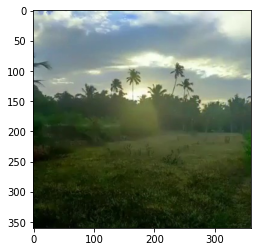

['geyser0.546579122543335', 'tank0.15377061069011688', 'amphibian0.09056275337934494', 'steam locomotive0.03908171504735947', 'valley0.020829105749726295']


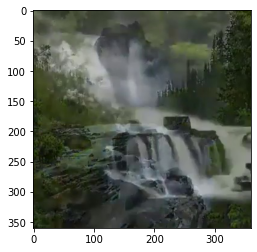

['suspension bridge0.48261237144470215', 'steel arch bridge0.05714781582355499', 'volcano0.05585658177733421', 'pier0.041293174028396606', 'cliff0.03562614694237709']


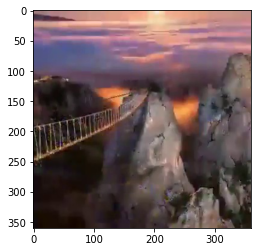

['alp0.20211261510849', 'geyser0.1843203604221344', 'valley0.1452322155237198', 'worm fence0.09078498929738998', 'lakeside0.06821557879447937']


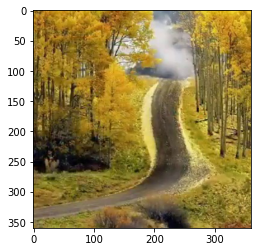

['balloon0.08859898149967194', 'lakeside0.07926147431135178', 'palace0.05451256036758423', 'beacon0.04726529121398926', 'flagpole0.043806564062833786']


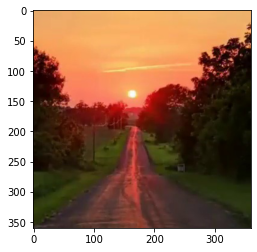

['alp0.21980370581150055', 'geyser0.1400129199028015', 'valley0.13974079489707947', 'worm fence0.111918605864048', 'lakeside0.06156941130757332']


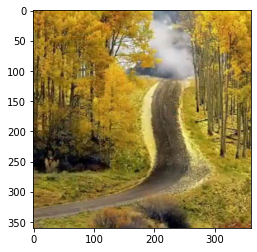

['valley0.9596984386444092', 'cliff0.0204986110329628', 'castle0.00436022924259305', 'lakeside0.002549112541601062', 'bighorn0.001558855059556663']


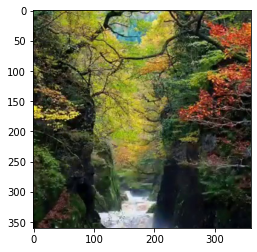

['valley0.6401670575141907', 'geyser0.13405174016952515', 'alp0.11186116933822632', 'cliff0.04217590391635895', 'lakeside0.0415194146335125']


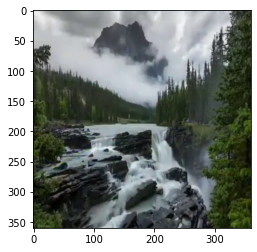

['boathouse0.19834209978580475', 'lakeside0.18315449357032776', 'steel arch bridge0.15767250955104828', 'dam0.1433970183134079', 'valley0.11805173754692078']


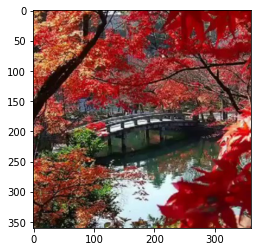

['picket fence0.06976339221000671', 'balloon0.06856580823659897', 'lakeside0.0672999918460846', 'traffic light0.06264384090900421', 'flagpole0.05608314648270607']


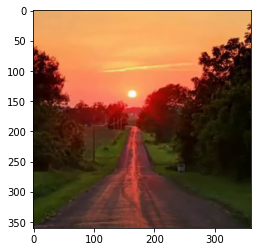

['harvester0.3510868549346924', 'balloon0.11324649304151535', 'rapeseed0.04445168003439903', 'trailer truck0.04040258377790451', 'plow0.036546602845191956']


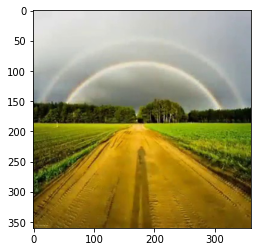

['dam0.7394965291023254', 'valley0.17884880304336548', 'fountain0.07478977739810944', 'geyser0.0015008588088676333', 'lakeside0.0013228635070845485']


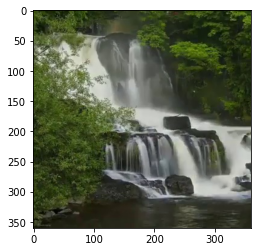

['valley0.9605326056480408', 'cliff0.028656112030148506', 'lakeside0.0037895699497312307', 'castle0.001759735750965774', 'alp0.0007680695271119475']


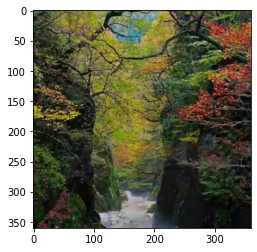

['valley0.2364673614501953', 'lakeside0.2168368101119995', 'alp0.20344869792461395', 'cliff0.06834281235933304', 'castle0.0362955704331398']


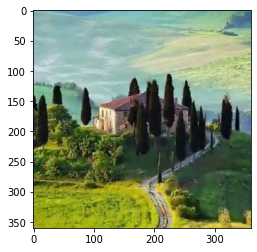

['lakeside0.20251250267028809', 'boathouse0.18386487662792206', 'steel arch bridge0.16452455520629883', 'valley0.12311431765556335', 'dam0.11801797896623611']


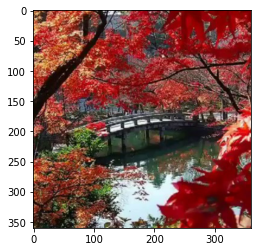

['alp0.3514036238193512', 'valley0.2098332941532135', 'lakeside0.12592393159866333', 'castle0.0686522126197815', 'cliff0.041744165122509']


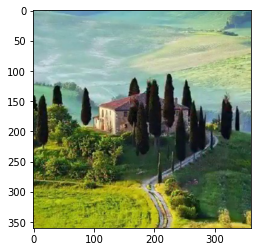

['valley0.6258959770202637', 'geyser0.16590334475040436', 'alp0.08794035762548447', 'lakeside0.04466922953724861', 'cliff0.03678208962082863']


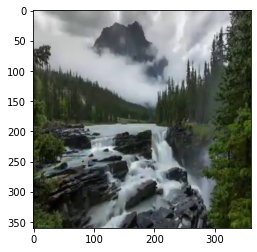

['lakeside0.14037644863128662', 'picket fence0.06642293930053711', 'palace0.06171994283795357', 'balloon0.05046960711479187', 'flagpole0.04475702717900276']


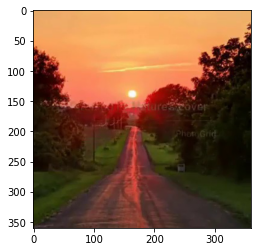

['balloon0.3685093820095062', 'harvester0.1563824564218521', 'viaduct0.11293783038854599', 'plow0.0269390307366848', 'radio telescope0.02628515288233757']


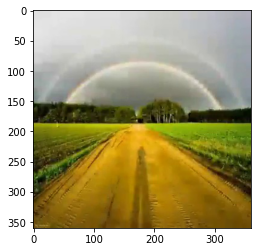

['lakeside0.20018014311790466', 'boathouse0.1817207634449005', 'steel arch bridge0.16945701837539673', 'dam0.12603309750556946', 'valley0.1167256310582161']


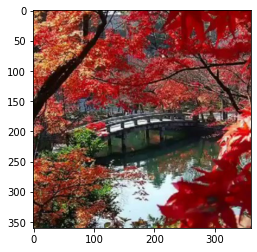

['volcano0.2599634826183319', 'alp0.09174026548862457', 'radio telescope0.08940353989601135', 'lakeside0.0840596929192543', 'valley0.06746991723775864']


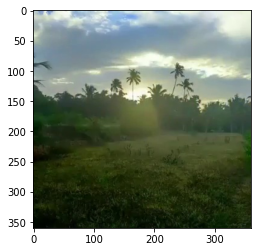

['valley0.772228479385376', 'castle0.03528410568833351', 'lakeside0.031786058098077774', 'cliff0.028696049004793167', 'alp0.0183192640542984']


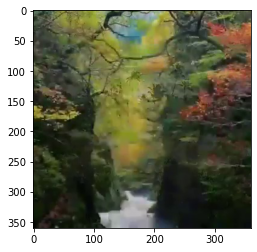

['suspension bridge0.2878783941268921', 'cliff0.19408974051475525', 'promontory0.12339235842227936', 'volcano0.07484696060419083', 'pier0.03544924780726433']


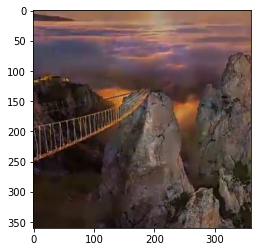

['suspension bridge0.6815466284751892', 'steel arch bridge0.04689965024590492', 'promontory0.04572949931025505', 'cliff0.03742905333638191', 'pier0.03160777688026428']


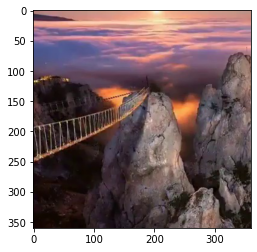

['dam0.8613767623901367', 'valley0.10345213860273361', 'fountain0.029842955991625786', 'geyser0.0014443866675719619', 'amphibian0.0008445449057035148']


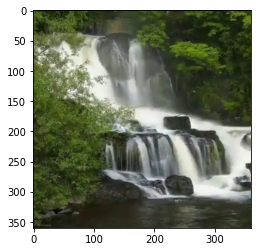

In [ ]:

%pylab inline
for i in range(0,len(all_imgs)):
    pic_path=folder_path+'/'+img_names[i]+img_exts[i]
    image = plt.imread(pic_path)
    img = plt.imshow(image)
    print(restext[i])
    plt.show()